# 0. 项目初始化
将`conditional-flow-matching`文件夹上传到kaggle中, 然后进行以下操作.本项目文件夹已经包含数据集`data/`,项目运行后,输出在模型文件夹`notes/models/`下.

In [1]:
cd /kaggle/input/cmf-experiment/conditional-flow-matching

/kaggle/input/cmf-experiment/conditional-flow-matching


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 8

# 1. 类胚体数据

## 单细胞时间序列插值

本笔记本在类胚体（embryoid body）数据上运行OT-CFM、SB-CFM和SF2M三种模型，数据预处理过程参考`preprocessing`（预处理）文件夹中的笔记本。本文中，我们优化了一个单一网络，用于在二维PHATE投影上对不同时间点的细胞进行建模。该流程同样适用于其他任何数据表征方式。在研究论文中，我们基于主成分分析（PCA）组件和高可变基因（highly variable genes）对模型进行了定量比较。

在本文的模型训练中，我们将所有时间点对整合为一个批次（batch）。在硬件支持大批次数据处理的情况下，这种方式被证明是最稳定的训练策略。

In [3]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

import warnings

# 忽略所有警告
warnings.filterwarnings("ignore")

# 模型路径
savedir = "/kaggle/working/models/ebdata"
os.makedirs(savedir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
adata = sc.read_h5ad("./data/Processed Single-cell RNA Time Series DAta/ebdata_v3.h5ad")
adata

AnnData object with n_obs × n_vars = 18203 × 17789
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate', '1d-phate-normalized'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_name', 'gene_id', 'gene_name_id'
    uns: 'diffmap_evals', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'sample_labels_colors', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_normalized', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs["sample_labels"]

AAACATTGAAAGCA-1_Day 00-03    Day 00-03
AAACCGTGCAGAAA-1_Day 00-03    Day 00-03
AAACCGTGGAAGGC-1_Day 00-03    Day 00-03
AAACGCACCGGTAT-1_Day 00-03    Day 00-03
AAACGCACCTATTC-1_Day 00-03    Day 00-03
                                ...    
TTTCTACTCTTATC-1_Day 24-27    Day 24-27
TTTCTACTTGAGCT-1_Day 24-27    Day 24-27
TTTGCATGATGACC-1_Day 24-27    Day 24-27
TTTGCATGCACTCC-1_Day 24-27    Day 24-27
TTTGCATGTTCTTG-1_Day 24-27    Day 24-27
Name: sample_labels, Length: 18203, dtype: category
Categories (5, object): ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']

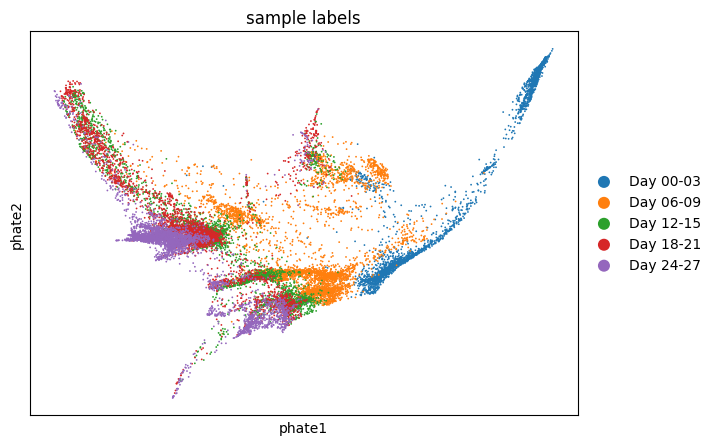

In [6]:
# phate降维后的图像
sc.pl.scatter(adata, basis="phate", color="sample_labels")

In [7]:
# n_times = 5,五个标签
n_times = len(adata.obs["sample_labels"].unique())
# Standardize coordinates
# 标准化坐标,分布为均值0方差1
coords = adata.obsm["X_phate"]
coords = (coords - coords.mean(axis=0)) / coords.std(axis=0)
adata.obsm["X_phate_standardized"] = coords
# X: 将坐标coords分为五个标签,每个标签含若干n_i个细胞,形状为 (5,n_i,2)
X = [
    adata.obsm["X_phate_standardized"][adata.obs["sample_labels"].cat.codes == t]
    for t in range(n_times)
]

In [8]:
# 此处模型可以选择mlp,gnn,dnn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
sigma = 0.1
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

In [9]:
import scprep

def plot_trajectories(traj, legend=True):
    n = 2000
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    scprep.plot.scatter(
        adata.obsm["X_phate_standardized"][:, 0],
        adata.obsm["X_phate_standardized"][:, 1],
        c=adata.obs["sample_labels"],
        ax=ax,
    )
    # ax.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.4, alpha=0.1, c="olive")
    # ax.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")

    for i in range(15):
        ax.plot(traj[:, i, 0], traj[:, i, 1], alpha=0.9, c="red")
    if legend:
        plt.legend([r"$p_0$", r"$p_t$", r"$p_1$", r"$X_t \mid X_0$"])
    # plt.xticks([])
    # plt.yticks([])
    # plt.axis("off")

def get_batch(FM, X, batch_size, n_times, return_noise=False):
    """Construct a batch with points from each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(n_times - 1):
        x0 = (
            torch.from_numpy(X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)])
            .float()
            .to(device)
        )
        x1 = (
            torch.from_numpy(
                X[t_start + 1][np.random.randint(X[t_start + 1].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        if return_noise:
            t, xt, ut, eps = FM.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut

# 1.1 OT-CFM
最优传输流匹配

In [10]:
loss_history = []  # 保存每1000步的loss
for i in tqdm(range(10000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, X, batch_size, n_times)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()
    # 每1000步记录loss
    if (i + 1) % 1000 == 0:
        loss_val = loss.item()
        loss_history.append(loss_val)
        tqdm.write(f"迭代步数: {i+1:5d} | Loss: {loss_val:.6f}")

 10%|█         | 1003/10000 [01:02<09:01, 16.62it/s]

迭代步数:  1000 | Loss: 0.159432


 20%|██        | 2003/10000 [02:04<08:32, 15.60it/s]

迭代步数:  2000 | Loss: 0.137517


 30%|███       | 3003/10000 [03:06<07:39, 15.22it/s]

迭代步数:  3000 | Loss: 0.098975


 40%|████      | 4003/10000 [04:08<06:08, 16.25it/s]

迭代步数:  4000 | Loss: 0.102321


 50%|█████     | 5003/10000 [05:10<05:16, 15.77it/s]

迭代步数:  5000 | Loss: 0.097282


 60%|██████    | 6003/10000 [06:11<04:09, 15.99it/s]

迭代步数:  6000 | Loss: 0.094359


 70%|███████   | 7003/10000 [07:13<03:07, 15.94it/s]

迭代步数:  7000 | Loss: 0.097037


 80%|████████  | 8001/10000 [08:16<02:08, 15.60it/s]

迭代步数:  8000 | Loss: 0.080577


 90%|█████████ | 9003/10000 [09:18<01:03, 15.81it/s]

迭代步数:  9000 | Loss: 0.075892


100%|██████████| 10000/10000 [10:20<00:00, 16.13it/s]

迭代步数: 10000 | Loss: 0.088445


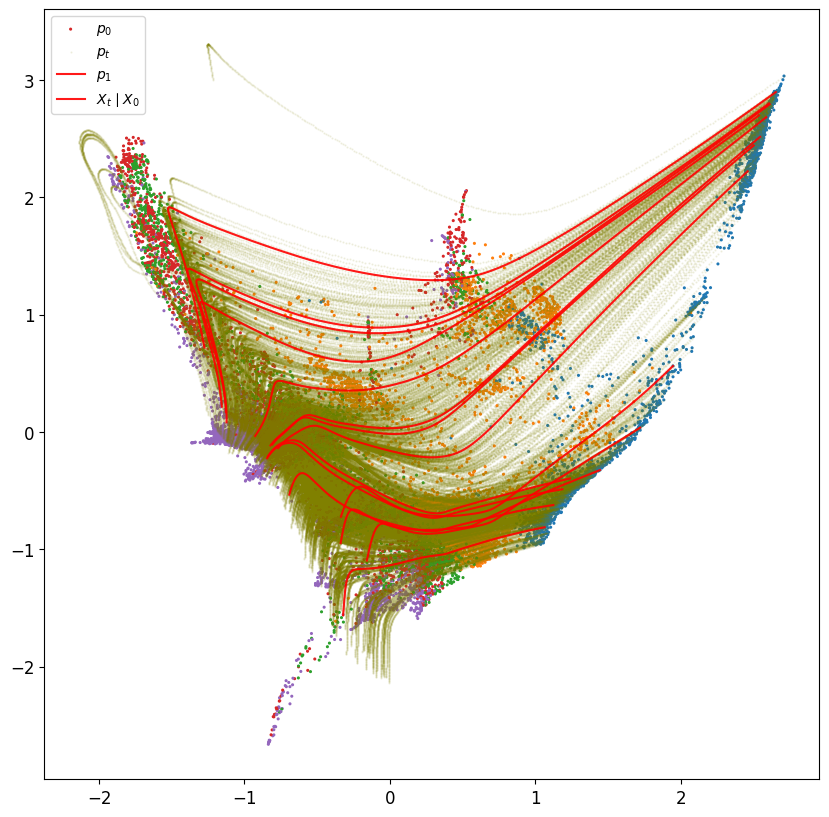

In [11]:
node = NeuralODE(torch_wrapper(ot_cfm_model), solver="dopri5", sensitivity="adjoint")
with torch.no_grad():
    traj = node.trajectory(
        torch.from_numpy(X[0][:1000]).float().to(device),
        t_span=torch.linspace(0, n_times - 1, 400),
    ).cpu()
    plot_trajectories(traj.cpu().numpy())

In [12]:
torch.save(
    {
        "model": ot_cfm_model,
        "optimizer": ot_cfm_optimizer,
        "loss_history": loss_history
    },
    f"{savedir}/ot_cfm_single_cell.pt",
)

# 1.2 SF2M
薛定谔桥条件流匹配

In [13]:
sigma = 0.25
sf2m_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_score_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_optimizer = torch.optim.AdamW(
    list(sf2m_model.parameters()) + list(sf2m_score_model.parameters()), 1e-4
)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)

In [14]:
max_norm_ut = torch.tensor(0.0)
loss_history = []
for i in tqdm(range(10000)):
    sf2m_optimizer.zero_grad()
    t, xt, ut, eps = get_batch(SF2M, X, batch_size, n_times, return_noise=True)
    lambda_t = SF2M.compute_lambda(t % 1)
    vt = sf2m_model(torch.cat([xt, t[:, None]], dim=-1))
    st = sf2m_score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    # max_norm_ut = torch.maximum(torch.max(torch.sum(ut**2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    if i % 1000 == 0:
        # print(max_norm_ut)
        
        print(f"iteration:{i}: flow_loss:{flow_loss.item():0.2f}, score_loss:{score_loss.item():0.2f}")
    loss = flow_loss + score_loss

    loss.backward()
    sf2m_optimizer.step()
    if (i + 1) % 1000 == 0:
        loss_val = loss.item()
        loss_history.append(loss_val)
        tqdm.write(f"迭代步数: {i+1:5d} | Loss: {loss_val:.6f}")

  0%|          | 4/10000 [00:00<11:36, 14.35it/s]

iteration:0: flow_loss:1.11, score_loss:1.25


 10%|█         | 1002/10000 [01:04<09:43, 15.43it/s]

迭代步数:  1000 | Loss: 1.261074
iteration:1000: flow_loss:0.41, score_loss:0.89


 20%|██        | 2002/10000 [02:10<08:32, 15.61it/s]

迭代步数:  2000 | Loss: 1.508494
iteration:2000: flow_loss:0.46, score_loss:0.89


 30%|███       | 3002/10000 [03:14<07:23, 15.79it/s]

迭代步数:  3000 | Loss: 1.408637
iteration:3000: flow_loss:0.22, score_loss:0.79


 40%|████      | 4002/10000 [04:18<06:23, 15.64it/s]

迭代步数:  4000 | Loss: 1.051229
iteration:4000: flow_loss:0.27, score_loss:0.80


 50%|█████     | 5002/10000 [05:22<05:30, 15.13it/s]

迭代步数:  5000 | Loss: 1.204996
iteration:5000: flow_loss:0.26, score_loss:0.79


 60%|██████    | 6002/10000 [06:26<04:26, 15.02it/s]

迭代步数:  6000 | Loss: 1.054969
iteration:6000: flow_loss:0.30, score_loss:0.82


 70%|███████   | 7002/10000 [07:30<03:19, 15.04it/s]

迭代步数:  7000 | Loss: 1.173206
iteration:7000: flow_loss:0.29, score_loss:0.81


 80%|████████  | 8002/10000 [08:34<02:07, 15.63it/s]

迭代步数:  8000 | Loss: 1.312237
iteration:8000: flow_loss:0.55, score_loss:0.82


 90%|█████████ | 9002/10000 [09:37<01:02, 15.87it/s]

迭代步数:  9000 | Loss: 1.199476
iteration:9000: flow_loss:0.31, score_loss:0.80


100%|██████████| 10000/10000 [10:40<00:00, 15.61it/s]

迭代步数: 10000 | Loss: 1.216939


In [15]:
node = NeuralODE(torch_wrapper(sf2m_model), solver="euler", sensitivity="adjoint")
x0 = torch.from_numpy(X[0][:1000]).float()
with torch.no_grad():
    traj = node.trajectory(
        x0.to(device),
        t_span=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

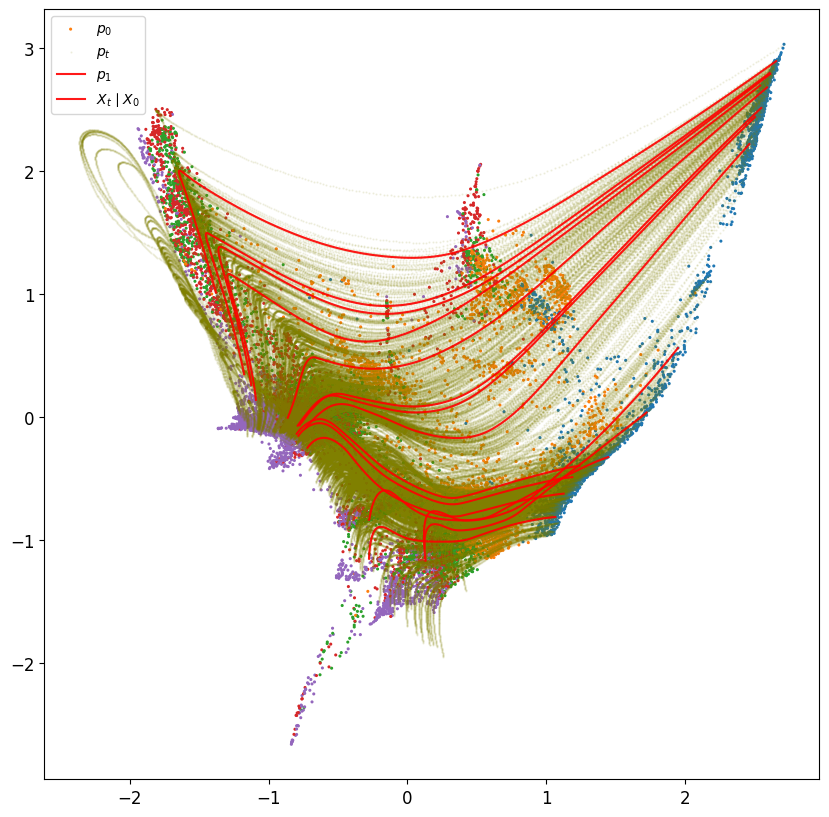

In [16]:
plot_trajectories(traj.cpu().numpy())

In [17]:
class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma

    # Drift
    def f(self, t, y):
        y = y.view(-1, *self.input_size)
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x).flatten(start_dim=1) + self.score(x).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma


sde = SDE(sf2m_model, sf2m_score_model, input_size=(2,), sigma=sigma)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        x0.to(device),
        ts=torch.linspace(0, n_times - 1, 400, device=device),
    ).cpu()

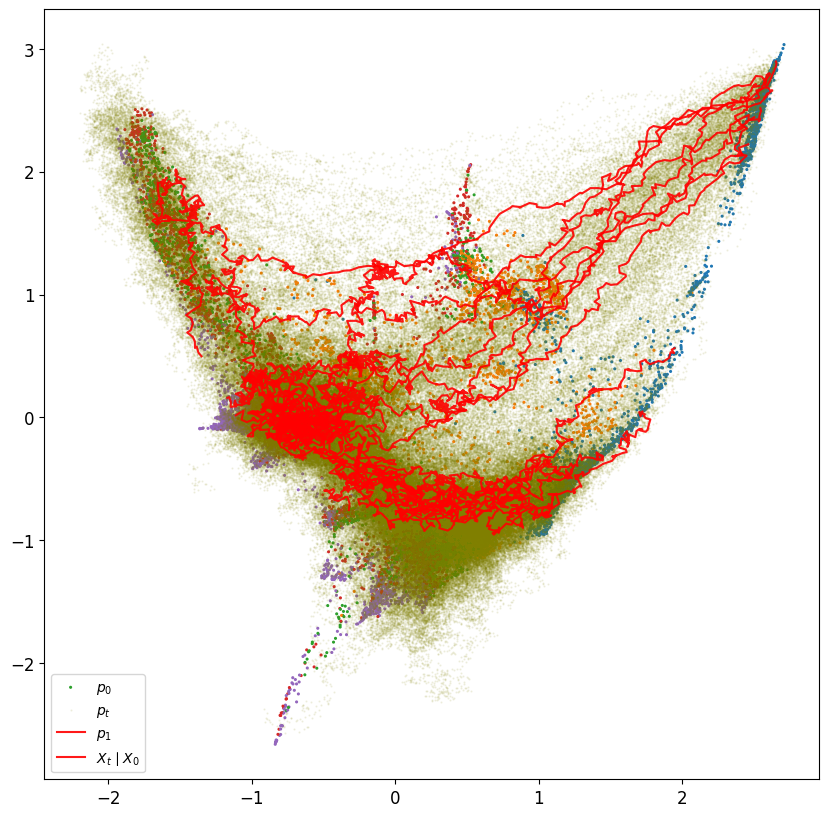

In [18]:
plot_trajectories(sde_traj.detach().cpu().numpy())


In [19]:
torch.save(
    {
        "model": sf2m_model,
        "score_model": sf2m_score_model,
        "optimizer": sf2m_optimizer,
        "loss_history": loss_history
    },
    f"{savedir}/sf2m_single_cell_sigma_{sigma}.pt",
)

## 1.3 SF2M_modified
1.3节以后为本人增加的实验。
由于原有的SF2M的损失函数不收敛, 考虑使用学习率衰减和梯度裁剪给予优化.
称为SF2M_modified, 即SF2M_modified增强版.
为了输出简洁,之后的实验主要看训练效果,即损失函数是否收敛,暂时不绘制图像.

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingLR
sigma = 0.25
sf2m_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_score_model = MLP(dim=dim, time_varying=True, w=64).to(device)
sf2m_optimizer = torch.optim.AdamW(
    list(sf2m_model.parameters()) + list(sf2m_score_model.parameters()), 1e-4
)
SF2M = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)


# -------------------------- 新增：学习率衰减 --------------------------
# CosineAnnealingLR：余弦退火衰减，10000步内从1e-4衰减到1e-6（避免后期震荡）
# T_max=训练总步数，eta_min=最小学习率（防止衰减到0导致停更）
scheduler = CosineAnnealingLR(
    optimizer=sf2m_optimizer,
    T_max=10000,  # 与训练总步数一致
    eta_min=1e-6,  # 最小学习率（可根据实际调整，如5e-7）
    last_epoch=-1  # 从头开始衰减
)


max_norm_ut = torch.tensor(0.0)
loss_history = []
# 新增：记录学习率变化（可选，用于调试）
lr_history = []

for i in tqdm(range(10000)):
    sf2m_optimizer.zero_grad()
    t, xt, ut, eps = get_batch(SF2M, X, batch_size, n_times, return_noise=True)
    lambda_t = SF2M.compute_lambda(t % 1)
    vt = sf2m_model(torch.cat([xt, t[:, None]], dim=-1))
    st = sf2m_score_model(torch.cat([xt, t[:, None]], dim=-1))
    flow_loss = torch.mean((vt - ut) ** 2)
    # max_norm_ut = torch.maximum(torch.max(torch.sum(ut**2, dim=1)), max_norm_ut)
    score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
    
    loss = flow_loss + score_loss

    loss.backward()
    # -------------------------- 新增：梯度裁剪 --------------------------
    # 限制所有参数的梯度 norm 不超过1.0（防止梯度爆炸，适配SBFM的损失特性）
    # 若flow_loss/score_loss波动仍大，可调整max_norm为0.5（更保守）或1.5（更宽松）
    torch.nn.utils.clip_grad_norm_(
        parameters=list(sf2m_model.parameters()) + list(sf2m_score_model.parameters()),
        max_norm=1.0,  # 核心参数：梯度的最大L2范数
        norm_type=2  # 用L2范数计算梯度大小
    )
    
    sf2m_optimizer.step()  # 参数更新
    scheduler.step()  # -------------------------- 新增：更新学习率 --------------------------

    if i % 1000 == 0:
            # print(max_norm_ut)
            loss_val = loss.item()
            print(f"iteration:{i}: flow_loss:{flow_loss.item():0.2f}, score_loss:{score_loss.item():0.2f}, loss:{loss_val:0.2f}")
            
            loss_history.append(loss_val)
            # 记录学习率
            current_lr = sf2m_optimizer.param_groups[0]['lr']
            lr_history.append(current_lr)
            print(f"迭代步数: {i} | 当前学习率: {current_lr:.8f}")
    

  0%|          | 3/10000 [00:00<13:35, 12.26it/s]

iteration:0: flow_loss:0.79, score_loss:1.20, loss:2.00
迭代步数: 0 | 当前学习率: 0.00010000


 10%|█         | 1003/10000 [01:03<09:33, 15.70it/s]

iteration:1000: flow_loss:0.30, score_loss:0.90, loss:1.20
迭代步数: 1000 | 当前学习率: 0.00009757


 20%|██        | 2003/10000 [02:06<08:44, 15.25it/s]

iteration:2000: flow_loss:0.33, score_loss:0.88, loss:1.21
迭代步数: 2000 | 当前学习率: 0.00009054


 30%|███       | 3003/10000 [03:10<07:36, 15.32it/s]

iteration:3000: flow_loss:0.24, score_loss:0.86, loss:1.10
迭代步数: 3000 | 当前学习率: 0.00007958


 40%|████      | 4003/10000 [04:14<06:09, 16.22it/s]

iteration:4000: flow_loss:0.43, score_loss:0.83, loss:1.26
迭代步数: 4000 | 当前学习率: 0.00006578


 50%|█████     | 5003/10000 [05:17<05:09, 16.16it/s]

iteration:5000: flow_loss:0.30, score_loss:0.79, loss:1.09
迭代步数: 5000 | 当前学习率: 0.00005048


 60%|██████    | 6003/10000 [06:20<04:19, 15.41it/s]

iteration:6000: flow_loss:0.34, score_loss:0.82, loss:1.16
迭代步数: 6000 | 当前学习率: 0.00003519


 70%|███████   | 7003/10000 [07:23<03:10, 15.73it/s]

iteration:7000: flow_loss:0.47, score_loss:0.79, loss:1.26
迭代步数: 7000 | 当前学习率: 0.00002139


 80%|████████  | 8003/10000 [08:28<02:15, 14.70it/s]

iteration:8000: flow_loss:0.44, score_loss:0.80, loss:1.24
迭代步数: 8000 | 当前学习率: 0.00001044


 90%|█████████ | 9003/10000 [09:31<01:02, 15.90it/s]

iteration:9000: flow_loss:1.17, score_loss:0.81, loss:1.98
迭代步数: 9000 | 当前学习率: 0.00000342


100%|██████████| 10000/10000 [10:35<00:00, 15.74it/s]


In [21]:
torch.save(
    {
        "model": sf2m_model,
        "score_model": sf2m_score_model,
        "optimizer": sf2m_optimizer,
        "loss_history": loss_history
    },
    f"{savedir}/sf2m_modified_single_cell_sigma_{sigma}.pt",
)

## 1.4 从高斯分布出发的CFM
用TargetConditionalFlowMatcher采样